<a href="https://colab.research.google.com/github/raymondyeo88/foodpanda_assessment/blob/main/Foodpanda_Data_Engineer_Take_Home.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Haversine libraries.

In [2]:
pip install haversine

In [ ]:
pip install git+https://github.com/pydata/pandas-gbq.git

In [23]:
from google.colab import auth
import pandas as pd
import pandas_gbq as gbq
import math
from haversine import haversine, Unit

# Colab Authentication and BigQuery Connection section

In [5]:
# Colab Authentication
auth.authenticate_user()
print('Authenticated')

Authenticated


In [15]:
# BigQuery Extension to run queries residing in BigQuery
# %load_ext google.cloud.bigquery
%reload_ext google.cloud.bigquery

In [16]:
# GCP Project ID
project_id = "glowing-indexer-329808"

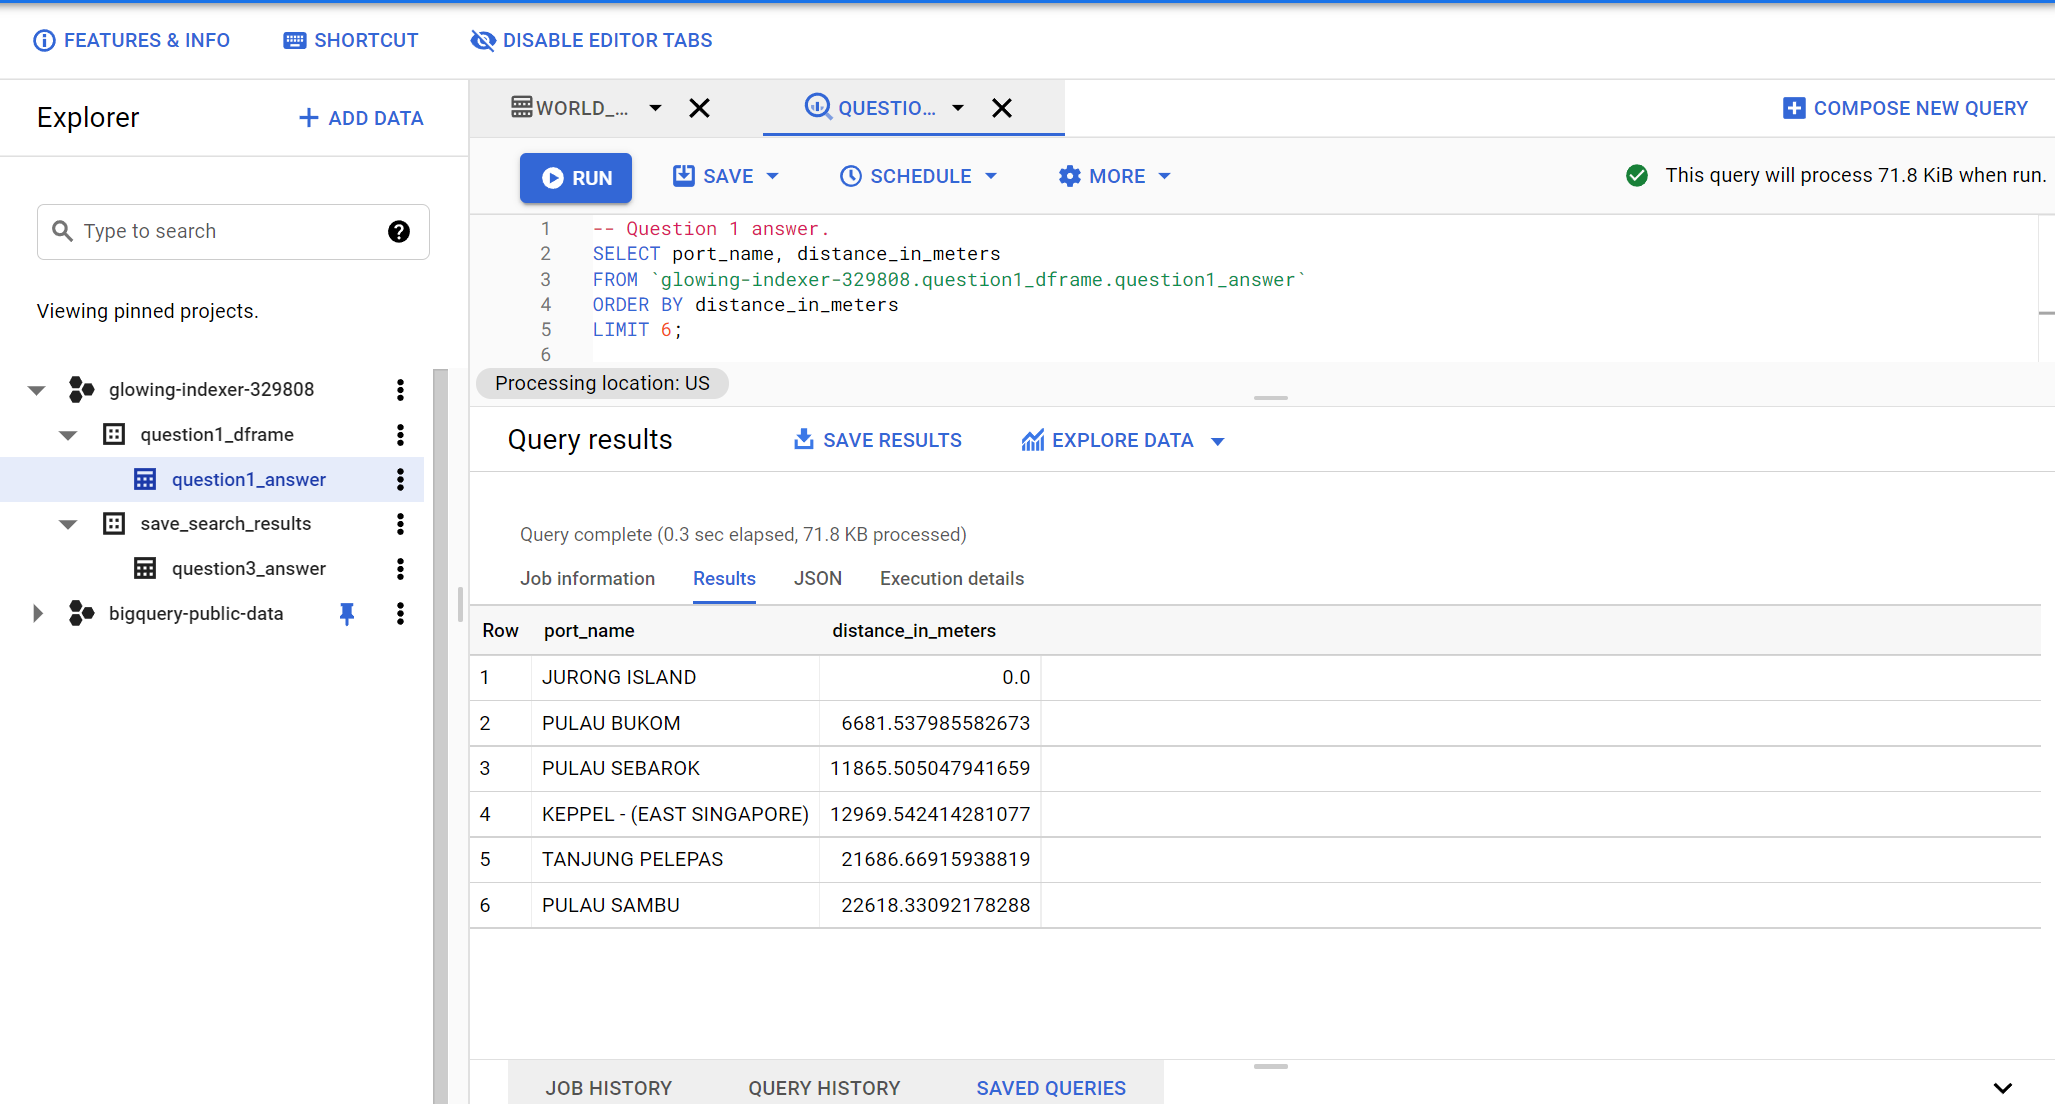

# Getting all data from BigQuery public Data => World Port Index

In [7]:
%%bigquery --project glowing-indexer-329808 world_port_index_dframe

SELECT *
FROM `bigquery-public-data.geo_international_ports.world_port_index`;

In [8]:
world_port_index_dframe.head()

,index_number,region_number,port_name,country,port_latitude,port_longitude,publication_number,chart_number,harbor_size,harbor_type,shelter_afforded,entry_tide,entry_swell,entry_ice,entry_other,overhead_limit,channel_depth,anchorage_depth,cargo_pier_depth,cargo_oil_depth,tide_range,max_vessel_size,good_holding_ground,turning_area,port_of_entry,us_representative,eta_message_required,pilot_required,pilot_available,pilot_local_assist,pilot_advised,tug_salvage,tug_assist,quarantine_procedures_required,quarantine_sscc_cert_required,quarantine_other,comms_phone,comms_fax,comms_radio,comms_vhf,comms_air,comms_rail,cargo_wharf,cargo_anchor,cargo_med_moor,cargo_beach_moor,cargo_ice_moor,med_facility,garbage_dispose,degauss,dirty_ballast,crane_fixed,crane_mobile,crane_float,lift_100_tons,lift_50_100_tons,lift_25_49_tons,lift_0_24_tons,services_longshore,services_electrical,services_steam,services_nav_equip,services_electrical_repair,provisions,water,fuel_oil,diesel,deck_supplies,eng_supplies,repair_types,dry_dock_types,railway_types,port_geom
0,50922,50920,MERAK MAS TERMINAL,ID,-5.916667,105.983333,150,None,M,CN,F,None,None,None,None,None,J,A,J,J,0,M,None,None,None,None,None,None,True,None,None,None,True,None,None,None,True,None,True,None,None,None,True,None,None,None,None,True,None,None,None,None,True,None,None,None,None,None,None,None,None,None,None,None,True,True,True,None,None,None,None,None,POINT(105.983333333333 -5.91666666666667)
1,47855,47840,DORALEH,DJ,11.600000,43.083333,172,None,S,CN,None,None,None,None,None,None,None,None,E,D,0,L,None,None,None,None,True,True,None,None,None,None,None,None,None,None,True,None,None,True,None,None,True,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,POINT(43.0833333333333 11.6)
2,8822,8650,SOUTHWEST PASS,US,28.450000,-90.700000,CP05,None,S,RN,N,False,False,False,True,None,None,None,None,J,0,M,None,None,None,None,None,None,True,True,None,None,None,None,None,None,True,None,None,None,None,None,True,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,True,None,None,None,None,None,None,None,None,None,None,None,None,None,POINT(-90.7 28.45)
3,2200,1930,PORT DE BECANCOUR,CA,46.400000,-72.383333,SCOR,None,V,RN,E,False,False,True,False,False,K,K,K,None,0,M,True,None,None,None,True,True,None,None,None,None,True,None,None,None,None,None,None,None,None,None,True,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,POINT(-72.3833333333333 46.4)
4,62635,62530,PORT BERINGOVSKY,RU,63.066667,179.366667,155,None,None,None,None,None,None,None,None,None,None,E,O,None,1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,POINT(179.366666666667 63.0666666666667)


In [9]:
world_port_index_dframe.shape

(3669, 73)

# Question 1

Q1/ What are the 5 nearest ports to Singapore's JURONG ISLAND port? (country = 'SG', port_name = 'JURONG ISLAND')

In [10]:
question1_dframe = world_port_index_dframe.copy()
distance_in_meters = []

question1_dframe.shape

(3669, 73)

In [11]:
dest_jurong_island_location = question1_dframe.loc[question1_dframe.port_name == "JURONG ISLAND", ["port_latitude","port_longitude"]]

jurong_island_location = float(dest_jurong_island_location.port_latitude.values), float(dest_jurong_island_location.port_longitude.values)

In [12]:
for index, rows in question1_dframe.iterrows():
  origin = float(rows["port_latitude"]), float(rows["port_longitude"])
  total_distance = haversine(origin,jurong_island_location, unit=Unit.METERS)
  distance_in_meters.append(total_distance)

question1_dframe["distance_in_meters"] = distance_in_meters

In [13]:
question1_dframe = question1_dframe.sort_values("distance_in_meters", ascending= True)

In [14]:
question1_dframe[["port_name","distance_in_meters"]].head(6)

,port_name,distance_in_meters
1115,JURONG ISLAND,0.000000
1116,PULAU BUKOM,6681.537986
1114,PULAU SEBAROK,11865.505048
1113,KEPPEL - (EAST SINGAPORE),12969.542414
2698,TANJUNG PELEPAS,21686.669159
3581,PULAU SAMBU,22618.330922


In [24]:
question1_answer_dataset = "question1_dframe.question1_answer"
gbq.to_gbq(question1_dframe, question1_answer_dataset,project_id)

1it [00:08,  8.87s/it]


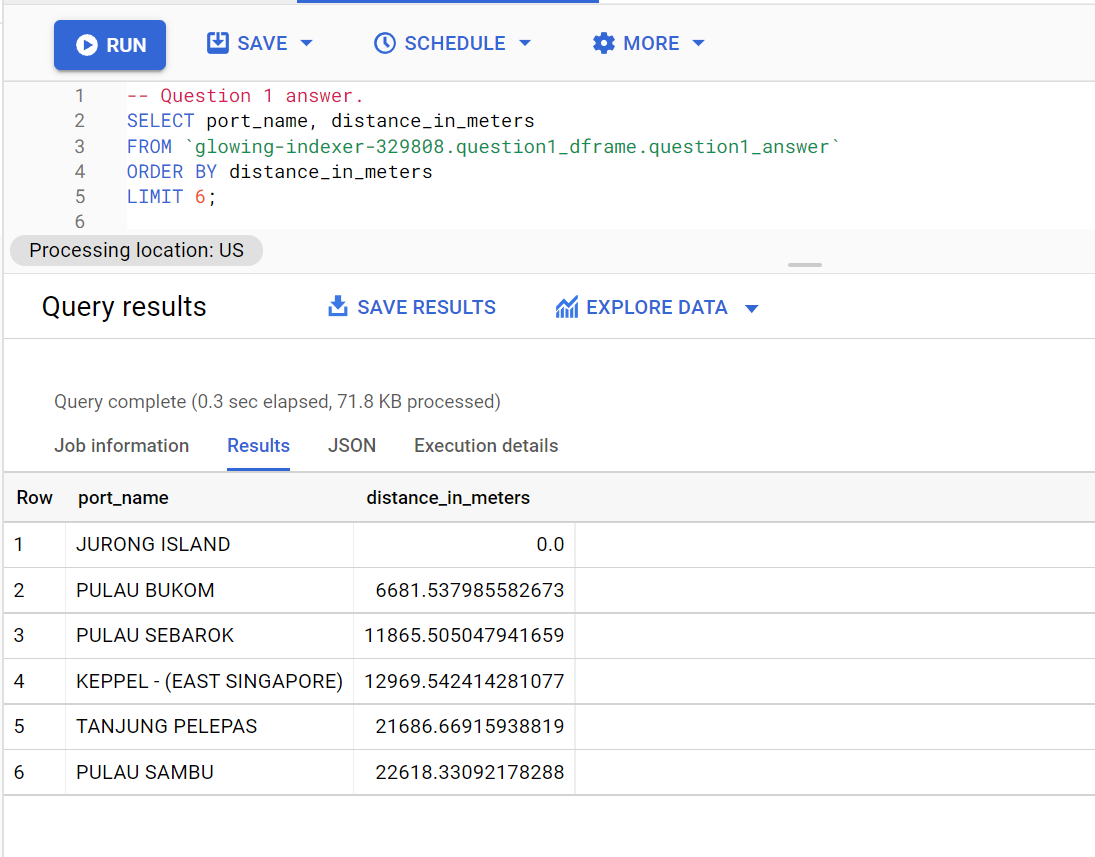

# Question 2

Q2/ Which country has the largest number of ports with a cargo_wharf? Your answer should include
the columns country and port_count only.

In [26]:
%%bigquery --project glowing-indexer-329808 

SELECT country, Count(*) AS port_count
FROM `bigquery-public-data.geo_international_ports.world_port_index`
WHERE cargo_wharf = TRUE 
GROUP BY country
ORDER BY port_count DESC 
LIMIT 1;

,country,port_count
0,US,583


# Question 3

Q3/ You receive a distress call from the middle of the North Atlantic Ocean. The person on the line gave you
a coordinates of lat: 32.610982, long: -38.706256 and asked for the nearest port with
provisions, water, fuel_oil and diesel. Your answer should include the columns
country, port_name, port_latitude and port_longitude only.

In [27]:
world_port_index_dframe.shape

(3669, 73)

In [28]:
question3_dframe = world_port_index_dframe.copy()
calculated_distance = []

question3_dframe.shape

(3669, 73)

In [29]:
given_coordinates_lat = 32.610982
given_coordinates_long = -38.706256

given_coordinates = given_coordinates_lat, given_coordinates_long

In [30]:
# Reusing question 1's for loop code
for index, row in question3_dframe.iterrows():
  country_location = float(row["port_latitude"]), float(row["port_longitude"])
  distance = haversine(country_location,given_coordinates, unit=Unit.METERS)
  calculated_distance.append(distance)

question3_dframe["distance_in_meters"] = calculated_distance

In [35]:
save_search_results = question3_dframe.loc[(question3_dframe["provisions"] == True) & (question3_dframe["water"] == True) & (question3_dframe["fuel_oil"] == True) & (question3_dframe["diesel"] == True), ["country","port_name","port_latitude","port_longitude", "distance_in_meters"]]

In [46]:
save_search_results.sort_values("distance_in_meters", ascending=True).head()

,country,port_name,port_latitude,port_longitude,distance_in_meters
2429,PT,HORTA,38.533333,-28.633333,1.122970e+06
531,PT,PRAIA DE VITORIA,38.716667,-27.050000,1.251335e+06
2430,PT,PONTA DELGADA,37.733333,-25.666667,1.313320e+06
1396,PT,FUNCHAL,32.633333,-16.916667,2.037061e+06
945,CA,ST JOHN'S,47.566667,-52.700000,2.038265e+06


In [41]:
save_search_results.shape

(1173, 5)

In [40]:
question3_answer_dataset = "save_search_results.question3_answer"
gbq.to_gbq(save_search_results, question3_answer_dataset,project_id)

1it [00:03,  3.08s/it]


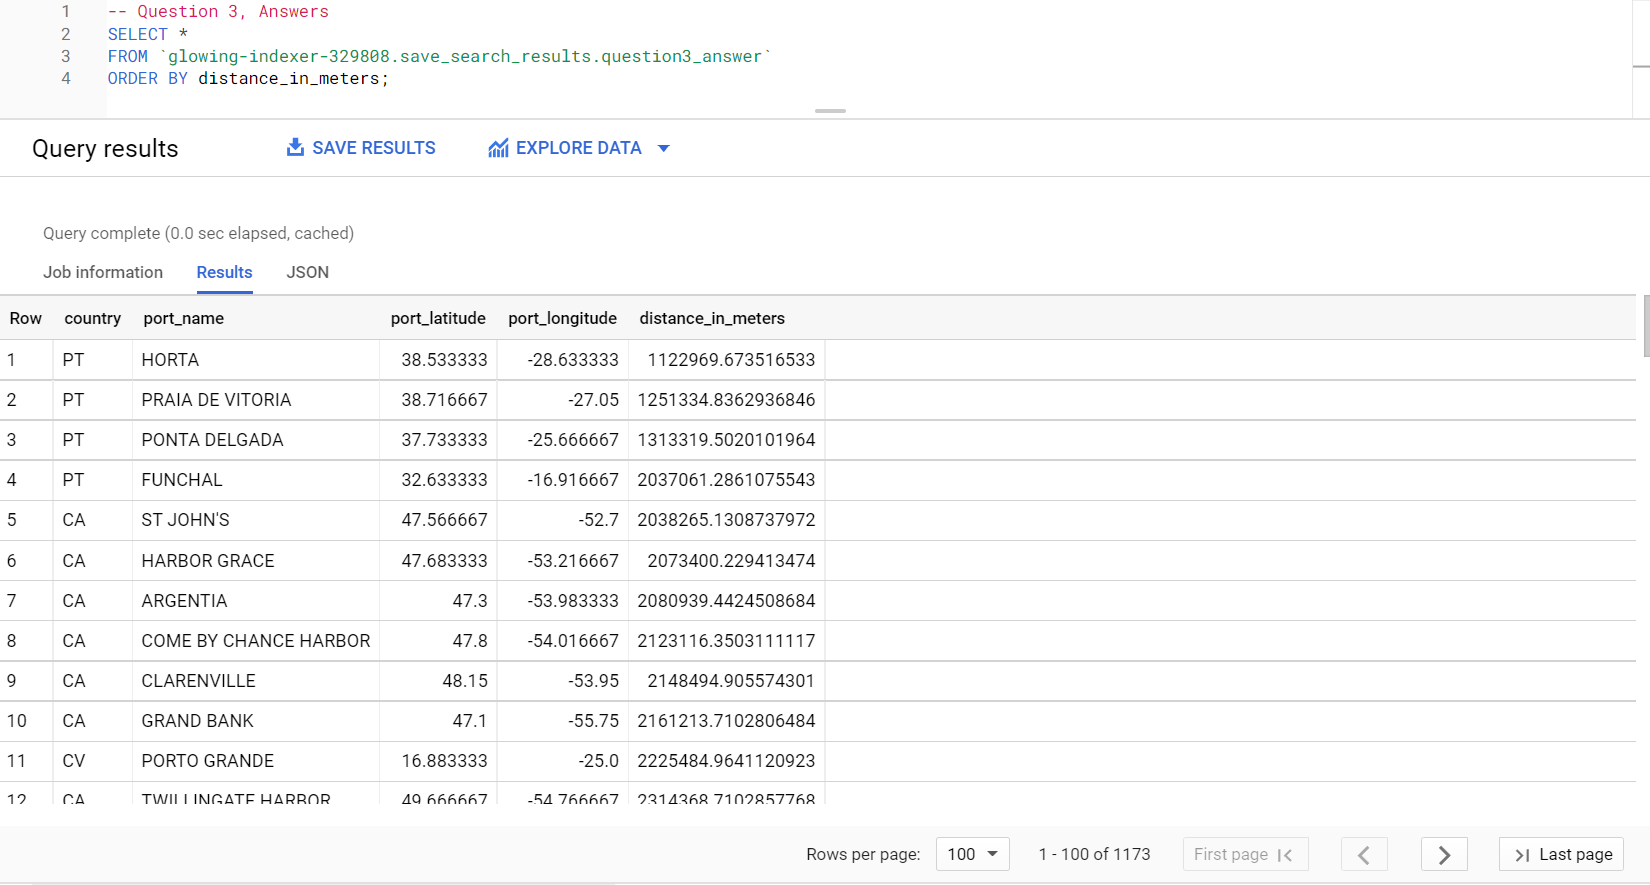